In [1]:
import os
import sys
import json
from collections import Counter
from scipy.integrate import solve_ivp
import numpy as np
from numpy.linalg import norm
from numpy import sqrt
from sklearn.metrics import accuracy_score
from math import pi
import pickle
import matplotlib.pyplot as plt
from packages import data_container
from packages.data_container import Data
from packages.helper import play_trajs, rotate, sp2a, v2sp, dist, psi, beta, d_theta, d_psi, sp2v, dist, min_dist, \
    vector_angle, signed_angle, side, inner, theta, min_sep
from packages.ode_simulator import ODESimulator
# For pickle to load the Data object, which is defined in packages.data_container
sys.modules['data_container'] = data_container

# file = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Raw_Data', 'Bai_movObst1_data.pickle'))
# with open(file, 'rb') as f:
#     data = pickle.load(f)

# file = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Raw_Data', 'Bai_movObst1b_data.pickle'))
# with open(file, 'rb') as f:
#     data2 = pickle.load(f)

file = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Raw_Data', 'Cohen_movObst_exp1_data.pickle'))
with open(file, 'rb') as f:
    data = pickle.load(f)

In [2]:
set(data.info['subj_id'])

{1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15}

In [6]:
'''Minimum Passing Distance'''
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title('Signed predicted minimum passing distance (SMPD)')
ax.set_ylabel('SMPD (m)')
ax.set_xlabel('normalized time (%)')
ax.set_ylim((-2, 2))
for i in range(len(data.trajs)):
    t0 = data.info['stimuli_onset'][i]
    t1 = data.info['stimuli_out'][i]
    p0 = data.info['p_subj'][i][t0:t1]
    p1 = data.info['p_obst'][i][t0:t1]
    v0 = data.info['v_subj'][i][t0:t1]
    v1 = data.info['v_obst'][i][t0:t1]
    t = np.linspace(0, 100, len(p0))
    smpd = []
    for _p0, _p1, _v0, _v1 in zip(p0, p1, v0, v1):        
        smpd.append(min_sep(_p0, _p1, _v0, _v1)[0])
    ax.plot(t, smpd, 'k', linewidth=0.1, alpha=0.5)
    
    

In [64]:
'''Animate data'''
############
subject = 0
trial = 31

############
%matplotlib qt
i = subject * 160 + trial - 1
i = 2
# p_obst = np.array(data.info['p_obst'][i])
t0 = data.info['stimuli_onset'][i]
p_goal = data.info['p_goal'][i]
p_subj = data.info['p_subj'][i]
p_obst = data.info['p_obst'][i]
trajs = [p_goal, p_obst, p_subj]
ws = [data.info['w_goal'], data.info['w_obst'], 0.4]
title = 'subj ' + str(data.info['subj_id'][i]) + ' trial ' + str(data.info['trial_id'][i]) + ' obst_angle: ' + str(data.info['obst_angle'][i]) + ' obst_speed: ' + str(data.info['obst_speed'][i])
play_trajs(trajs, ws, data.Hz, title=title)
print(data.info['subj_id'][i], data.info['trial_id'][i])

10 12


In [9]:
'''Plot acceleration angle and magnitude'''
%matplotlib qt
trials = range(400,401)
subject = 1
con_angle = [90, -90]
con_speed = []
fig0 = plt.figure()
ax0 = fig0.add_subplot()
fig1 = plt.figure()
ax1 = fig1.add_subplot()
for i in trials:
    angle = data.info['obst_angle'][i]
    speed = data.info['obst_speed'][i]
    subj_id = data.info['subj_id'][i]
    if i in data.dump:
        continue
#     if angle not in con_angle or subj_id != subject:
#         continue
    t0, t1 = data.info['stimuli_onset'][i], data.info['stimuli_out'][i]
    p0, p1, a0 = np.array(data.info['p_subj'][i][t0:t1]), np.array(data.info['p_obst'][i][t0:t1]), np.array(data.info['a_subj'][i][t0:t1])
    angles = signed_angle(p1 - p0, a0)
    ax0.scatter(range(len(angles)), angles, s=1)
    ax1.plot(norm(a0, axis=-1))
    print(data.info['subj_id'][i], data.info['trial_id'][i])

15 47


In [66]:
'''Plot dpsi dtheta by time'''
%matplotlib qt
subjects = range(16)
n = len(data.trajs)
fig0 = plt.figure()
ax0 = fig0.add_subplot()
fig1 = plt.figure()
ax1 = fig1.add_subplot()
fig2 = plt.figure()
ax2 = fig2.add_subplot()
for i in range(2,3):
    if (data.info['subj_id'][i] in subjects and
        i not in data.dump and
        data.info['obst_speed'][i] != 0 and
        abs(data.info['obst_angle'][i]) != 180):
        t0, t1 = data.info['stimuli_onset'][i], data.info['stimuli_out'][i]
        p0, p1 = np.array(data.info['p_subj'][i][t0:t1]), np.array(data.info['p_obst'][i][t0:t1])
        v0, v1 = np.array(data.info['v_subj'][i][t0:t1]), np.array(data.info['v_obst'][i])
        a0 = np.array(data.info['a_subj'][i][t0:t1])
        a0 = norm(a0, axis=-1)
        v1 = np.tile(v1, (len(v0), 1))
        dpsis = np.absolute(d_psi(p0, p1, v0, v1))
        dthetas = d_theta(p0, p1, v0, v1, w=0.1)
        thetas = theta(p0, p1, w=0.1)
        ratio = dthetas/thetas
        ax0.plot(a0)
        c1, c2 = 0, 0.2
        ax1.plot((ratio+c1)/(dpsis+c2))
        ax2.scatter(ratio[60:80], a0[60:80], s=1)
#         ax2.scatter(range(len(dpsis)), dthetas/dpsis, s=1)

In [4]:
'''Plot data by condition'''
#####################
subject = 2
con_ang = [90]
con_spd = [1.2]
# con_ang = set(data.info['obst_angle'])
# con_spd = set(data.info['obst_speed'])
#####################
%matplotlib qt
plt.figure()
for i in range(len(data.trajs)):
    obst_speed = data.info['obst_speed'][i]
    obst_angle = data.info['obst_angle'][i]
    subj_id = data.info['subj_id'][i]
    if subj_id != subject:
        continue
    if not (obst_speed in con_spd and abs(obst_angle) in con_ang):
        continue
    subj = np.array(data.get_traj(i))
    obst = np.array(data.info['p_obst'][i])
    if i % 2 == 0:
        subj = rotate(subj, np.arctan(11 / 9) - pi / 2)
        obst = rotate(obst, np.arctan(11 / 9) - pi / 2)
    else:
        subj = rotate(subj, np.arctan(11 / 9) + pi / 2)
        obst = rotate(obst, np.arctan(11 / 9) + pi / 2)
    if obst_angle < 0:
        subj[:, 0] *= -1
        obst[:, 0] *= -1
    plt.plot(subj[:, 0], subj[:, 1])
    plt.plot(obst[:, 0], obst[:, 1])
ax = plt.gca()
ax.set_aspect('equal')
ax.set_title('subj ' + str(subject) + ' angle: ' + str(con_ang[0]) + ' speed: ' + str(con_spd[0]))

Text(0.5, 1.0, 'subj 2 angle: 90 speed: 1.2')

In [ ]:
'''Plot data by subject'''
#####################
subject = 3
#####################
%matplotlib qt
fig = plt.figure()
fig.suptitle('Subject ' + str(subject))
axes = {}
obst_angle = [90, 112.5, 135, 157.5, 180]
obst_speed = [0.9, 1.0, 1.1, 1.2, 1.3]
i_plot = 1
for angle in obst_angle:
    for speed in obst_speed:
        axes[(angle, speed)] = fig.add_subplot(5, 5, i_plot)
        axes[(angle, speed)].set_xlim(-3, 3)
        axes[(angle, speed)].set_ylim(-7, 5)
        axes[(angle, speed)].set_title(str(angle) + '° ' + str(speed) + 'm/s')
        axes[(angle, speed)].set_aspect('equal')
        i_plot += 1
for i in range(len(data.trajs)):
    speed = data.info['obst_speed'][i]
    angle = data.info['obst_angle'][i]
    subj_id = data.info['subj_id'][i]
    if subj_id != subject or speed == 0:
        continue
    subj = np.array(data.info['p_subj'][i])
    obst = np.array(data.info['p_obst'][i])
    if i % 2 == 0:
        subj = rotate(subj, np.arctan(11 / 9) - pi / 2)
        obst = rotate(obst, np.arctan(11 / 9) - pi / 2)
    else:
        subj = rotate(subj, np.arctan(11 / 9) + pi / 2)
        obst = rotate(obst, np.arctan(11 / 9) + pi / 2)
    if angle < 0:
        subj[:, 0] *= -1
        obst[:, 0] *= -1
    axes[(abs(angle), speed)].plot(subj[:, 0], subj[:, 1])
    axes[(abs(angle), speed)].plot(obst[:, 0], obst[:, 1])

{1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15}
Loading finished
passing order matching rate  0.8238805970149253


Text(0.5, 0, 'dpsi')

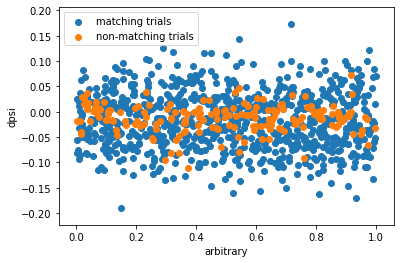

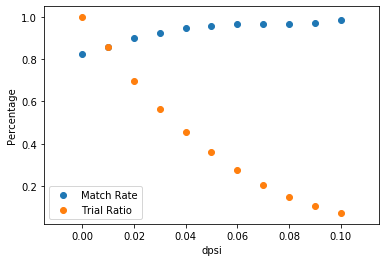

In [3]:
'''Check initial dpsi and subject passing choice, plot dpsi of matching and non-matching trials'''
subjects = set(data.info['subj_id'])
print(subjects)
sim = ODESimulator(data=data, ref=[0,1])
side_pred = []
side_true = []
dpsi_match = []
dpsi_not = []
for i in range(len(sim.data.trajs)):
    if (sim.data.info['subj_id'][i] in subjects and
        i not in sim.data.dump and
        sim.data.info['obst_speed'][i] != 0 and
        abs(sim.data.info['obst_angle'][i]) != 180):
        xg, yg, xo, yo, vxo, vyo, x, y, vx, vy, a, phi, s, dphi, ds = sim.compute_var0(i, sim.data.info['stimuli_onset'][i])
        # When beta and dpsi has the same sign it means pass in front, otherwise it means pass from behind
        dpsi = d_psi([x, y], [xo, yo], [vx, vy], [vxo, vyo])
        b = beta([x, y], [xo, yo], [vx, vy])
        side_pred.append(1 if b * dpsi > 0 else -1)
        side_true.append(sim.data.info['pass_order'][i])
        if side_pred[-1] == side_true[-1]:
            dpsi_match.append(dpsi)
        else:
            dpsi_not.append(dpsi)
print('passing order matching rate ', accuracy_score(side_true, side_pred))
plt.scatter(np.random.uniform(size=len(dpsi_match)), dpsi_match, label='matching trials')
plt.scatter(np.random.uniform(size=len(dpsi_not)), dpsi_not, label='non-matching trials')
plt.ylabel('dpsi')
plt.xlabel('arbitrary')
plt.legend()
thress = np.linspace(0, 0.1, 11)
match_rates = []
trial_ratios = []
for thres in thress:
    a, b = sum([abs(x) > thres for x in dpsi_match]), sum([abs(x) > thres for x in dpsi_not])
    match_rates.append(a/(a+b))
    trial_ratios.append((a+b)/len(side_pred))
plt.figure()
plt.scatter(thress, match_rates, label='Match Rate')
plt.scatter(thress, trial_ratios, label='Trial Ratio')
plt.legend()
plt.ylabel('Percentage')
plt.xlabel('dpsi')
# print(a/(a+b), ' matching rate for trials with initial dpsi smaller than ', thres)


In [13]:
'''Check trial length from match_onset to stimuli_out'''
match_onsets = []
lens = []
for i in range(len(data.trajs)):
    if i not in data.dump:
        p0 = data.info['p_subj'][i]
        p1 = data.info['p_obst'][i]
        v0 = data.info['v_subj'][i]
        v1 = data.info['v_obst'][i]
        stimuli_out = data.info['stimuli_out'][i]
        stimuli_onset = data.info['stimuli_onset'][i]
        match_onset = data.info['match_onset'][i]
        dpsis = d_psi(p0, p1, v0, v1)
        if stimuli_out - match_onset <= 30:
            plt.plot(dpsis)
            plt.plot(dpsis[match_onset:stimuli_out])
            print(i)
        match_onsets.append(data.info['match_onset'][i])
        lens.append(data.info['stimuli_out'][i] - data.info['match_onset'][i])
# plt.hist(match_onsets)
# plt.figure()
# plt.hist(lens)

849
924


In [ ]:
'''Approach data'''
'''Plot data by condition'''
#####################
subject = 0
s0 = [1.4]
d0 = [8]
angle = [15]
s0 = set(data2.info['goal_s0'])
d0 = set(data2.info['goal_d0'])
angle = set(data2.info['goal_angle'])
#####################
%matplotlib qt
plt.figure()
for i in range(len(data2.trajs)):
    goal_s0 = data2.info['goal_s0'][i]
    goal_d0 = data2.info['goal_d0'][i]
    goal_angle = data2.info['goal_angle'][i]
    subj_id = data2.info['subj_id'][i]
    if subj_id != subject:
        continue
    if not (goal_s0 in s0 and goal_d0 in d0 and abs(goal_angle) in angle):
        continue
    subj = np.array(data2.info['p_subj'][i])
    goal = np.array(data2.info['p_goal'][i])
    if i % 2 == 0:
        subj = rotate(subj, np.arctan(11 / 9) - pi / 2)
        goal = rotate(goal, np.arctan(11 / 9) - pi / 2)
    else:
        subj = rotate(subj, np.arctan(11 / 9) + pi / 2)
        goal = rotate(goal, np.arctan(11 / 9) + pi / 2)
#     if goal_angle < 0:
#         subj[:, 0] *= -1
#         goal[:, 0] *= -1
    plt.plot(subj[:, 0], subj[:, 1])
    print(subj)
    plt.plot(goal[:, 0], goal[:, 1])
ax = plt.gca()
ax.set_aspect('equal')
ax.set_title(f'subj {str(subject)} angle: {str(angle)} s0: {str(s0)} d0: {str(d0)}')

In [3]:
'''Cohen experiments'''
file = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Raw_Data', 'Cohen_movObst_exp1_data.pickle'))
with open(file, 'rb') as f:
    cohen1 = pickle.load(f)

In [ ]:
cohen1.info['pass_order']
# data.info['pass_order']

In [3]:
''' Check optimal parameters from training results '''
bests = {} 
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Results', 'cohen_movObst1_cohen_avoid1&2&34&4_thres_differential_evolution'))
filenames = [os.path.join(path, name) for name in os.listdir(path) if name[-3:] == 'txt']
filenames = [filenames[2]]
# b1s = []
# k1s = []
errs = []
for filename in filenames:
    with open(filename, 'rb') as f:
        best = 0
        e_min = float('inf')
        for i, line in enumerate(f):
            if i == 1:
                subj_id = int(line[-4:-2])
            if i >= 5:
                try:
                    err = str(line).split("\\t")[-3][:10]
                    if err[0] == '0':
                        err = float(err)
                        if err < e_min:
                            e_min = err
                            best = str(line).replace("\\", "")
                except:
                    pass
                # Find all parameters that have small error
#                 if subj_id == 0 and float(err) < 0.16:
#                     model = str(line).split("\\t")[1].split("}")[1][1:] + '}'
#                     model = model.replace('\'', '\"')
#                     d = json.loads(model)
#                     b1s.append(d['b1'])
#                     k1s.append(d['k1'])
#                     errs.append(float(err))
    bests[subj_id] = best
for i, best in bests.items():
    print('\n')
    print(i, best)



-1 b"5133t[{'name': 'fajen_approach', 'b1': 2.01938384, 'k1': 4.90527274, 'c1': 2.96094879, 'c2': 0.50896525, 'k2': 1.61216734, 'ps': 1.3075058885951525}, {'name': 'cohen_avoid2', 'b1': 1.313894780845967, 'k1': 393.59559030933247, 'c5': 8.82965005381204, 'c6': 2.3410827991863172, 'b2': 0.0003485317797959908, 'k2': 66.77017554542931, 'c7': 7.602409489606929, 'c8': 1.5994854927685118, 'ps': 1.3075058885951525}]t0.19380049776952585torder_accuracyt0.835820895522388rn"


In [70]:
bests

{-1: 'b"5226t[{\'name\': \'fajen_approach2\', \'b1\': 2.04992354, \'k1\': 2.85641543, \'c1\': 0.54294928, \'c2\': 0.73857217, \'b2\': 3.89580222, \'k2\': 5.04511601, \'ps\': 1.3075058885951525}, {\'name\': \'cohen_avoid4_thres\', \'k1\': 2.88211554599569, \'c5\': 1.8402080467654376, \'c6\': 10.786835005989973, \'k2\': 3.380457830359567, \'c7\': 5.4360445618996565, \'c8\': 12.67287871326611, \'thres\': 0.006145124061037794, \'ps\': 1.3075058885951525}]t0.1816487976225869torder_accuracyt0.672636815920398rn"'}

In [54]:
%matplotlib qt
plt.plot(errs)
plt.figure()
plt.scatter(b1s, k1s)